In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *
from utils import *

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_22050_trimmed_tfms'

CSV = DATA/'freesound/audio_44KHz/train_with_lens.csv'
TEST_CSV = DATA/'freesound/audio_44KHz/test_with_lens.csv'

In [6]:
df = pd.read_csv(CSV)
if df['fname'].iloc[0].endswith('.wav'):
    df['fname'] = df['fname'].str[:-4]
    df.drop(['manually_verified'], axis=1, inplace=True)

# validation split; stratified by label
idx = np.arange(len(df))
train_idx, valid_idx = train_test_split(idx, test_size=0.2, stratify=df['label'])
df['valid'] = False
df.loc[df.iloc[valid_idx].index, 'valid'] = True

df.head(10)

,fname,label,n_samples,valid
0,00044347,Hi-hat,617400,True
1,001ca53d,Saxophone,455112,False
2,002d256b,Trumpet,19404,True
3,0033e230,Glockenspiel,352800,False
4,00353774,Cello,199332,True
5,003b91e8,Cello,585648,True
6,003da8e5,Knock,59976,False
7,0048fd00,Gunshot_or_gunfire,45864,True
8,004ad66f,Clarinet,308700,False
9,0063ab88,Computer_keyboard,1307124,False


In [ ]:
def tfm_df(df, n_tfms=5):
    dfs = []
    for i in range(n_tfms + 1):
        suffix = '_{:02d}'.format(i)
        new_df = df.copy()
        new_df['fname'] = new_df['fname'] + suffix
        dfs.append(new_df)
    tfm_df = pd.concat(dfs)
    return tfm_df
        
df_tfm = tfm_df(df)
df_tfm.head(5)

In [ ]:
# two files were corrupt when generating transformed files, just remove them from df
df_tfm = df_tfm[~df_tfm['fname'].isin(['255db1a8_05', 'f406520b_01'])]
drop_idx = (df_tfm['valid'] == True) & (~df_tfm['fname'].str.endswith('_00'))
df_final = df_tfm[~drop_idx]
len(df_tfm), df_final['valid'].sum(), (~df_final['valid']).sum()

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, residual=False):
        super().__init__()
        self.res = residual
        self.conv = nn.Conv2d(in_channels, 
                         out_channels,
                         kernel_size=kernel_size, 
                         stride=stride,
                         padding=padding, 
                         bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        out = self.conv(x)
        if self.res:
            out = residual + out
        out = self.batch_norm(out)
        out = self.relu(out)
        return out

class AudioCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        layers = []

        # B1 to B5
        in_channels = 1
        num_filters = [16, 32, 64, 128, 256]
        for out_channels in num_filters:
            layers += [ResBlock(in_channels,  out_channels, kernel_size=3, padding=1, residual=False),
                       ResBlock(out_channels, out_channels, kernel_size=3, padding=1, residual=True),
                       nn.MaxPool2d(2)]
            in_channels = out_channels
        
        # B6
        layers += [ResBlock(256, 512, kernel_size=3, padding=1), nn.MaxPool2d(2)]
        
        # F1
        layers += [ResBlock(512, 1024, kernel_size=3, padding=1)]
        
        # F2
        layers += [nn.Conv2d(1024, n_classes, 3, padding=1)]
        
        # Reshape 
        layers += [
            PoolFlatten()
        ]
                
        self.layers = nn.Sequential(*layers)

        # from ResNet 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
        
    def forward(self, x):
        return self.layers(x)

In [8]:
n_fft = 2048
n_hop = 256
n_mels = 128
sample_rate = 22050
bs = 16

tfms = get_transforms(n_hop=n_hop)

batch_tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                            n_mels=n_mels, sample_rate=sample_rate)

test_df = pd.read_csv(TEST_CSV)
test_data = AudioItemList.from_df(test_df, path=AUDIO, folder='test', suffix='.wav')

In [9]:
AUDIO = DATA/'freesound/audio_22050_trimmed'

data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .split_from_df('valid')
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, tfms=batch_tfms, length_col=2))

len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(7578, 1895, 9400)

In [10]:
model = AudioCNN(527)
model.load_state_dict(torch.load('audioset_16epochs.pt'))

In [12]:
head = nn.Sequential(nn.Conv2d(1024, data.c, kernel_size=3, stride=1, padding=1),
                     PoolFlatten())
cut = -2

In [13]:
metrics = [accuracy, mapk]
learn = create_audio_cnn(data, model, cut, head=head, metrics=metrics)

In [14]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 16, 128, 2204]  144        False     
______________________________________________________________________
BatchNorm2d          [16, 16, 128, 2204]  32         True      
______________________________________________________________________
ReLU                 [16, 16, 128, 2204]  0          False     
______________________________________________________________________
Conv2d               [16, 16, 128, 2204]  2304       False     
______________________________________________________________________
BatchNorm2d          [16, 16, 128, 2204]  32         True      
______________________________________________________________________
ReLU                 [16, 16, 128, 2204]  0          False     
______________________________________________________________________
MaxPool2d            [16, 16, 64, 1102]   0          False     
______________________________________________________________

In [15]:
model_name = 'freesound_finetuned_v2'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,3.402095,3.196076,0.282850,0.407036
2,2.252634,2.120467,0.403166,0.523131
3,1.976084,1.944162,0.434301,0.553386
4,1.789434,1.884910,0.465435,0.579771
5,1.684179,1.849449,0.472296,0.590061
6,1.720191,1.842070,0.479683,0.595778
7,1.643252,1.827194,0.487599,0.604046
8,1.573119,1.818071,0.485488,0.603166


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


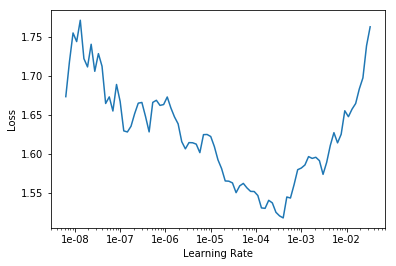

In [16]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1e-1)
learn.recorder.plot()

In [19]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=1e-4)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy,mapk
1,1.576508,1.804947,0.497625,0.610642
2,1.474343,1.768979,0.504485,0.616359
3,1.507875,1.718481,0.516623,0.630079
4,1.437056,1.690476,0.528232,0.640369
5,1.419249,1.648395,0.545119,0.650132
6,1.325427,1.617614,0.551979,0.657696
7,1.289737,1.623900,0.554090,0.658927
8,1.299599,1.612007,0.554090,0.659631


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


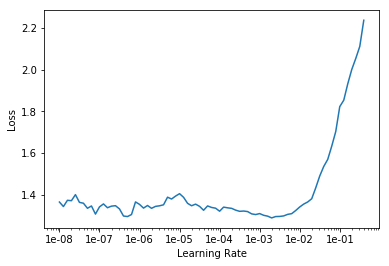

In [21]:
learn.load(model_name + '-stage-2')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1e1)
learn.recorder.plot()

In [22]:
learn.load(model_name + '-stage-2')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,accuracy,mapk
1,1.265276,1.542805,0.563588,0.669041
2,1.338450,1.653530,0.554090,0.660158
3,1.164451,1.414444,0.613193,0.702551
4,1.002989,1.350735,0.649077,0.734741
5,0.818294,1.287038,0.675462,0.756465
6,0.655343,1.236616,0.703958,0.776605
7,0.578368,1.214611,0.708707,0.780739
8,0.526164,1.180479,0.713984,0.785928


In [24]:
learn.load(model_name + '-stage-3')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-4')

epoch,train_loss,valid_loss,accuracy,mapk
1,0.518674,1.297344,0.693931,0.770185
2,0.702204,1.334867,0.697625,0.775374
3,0.710204,1.400598,0.664380,0.748197
4,0.619795,1.532186,0.671240,0.749692
5,0.494722,1.293619,0.720317,0.793931
6,0.366797,1.237247,0.736675,0.800880
7,0.276208,1.309802,0.732454,0.801495
8,0.230140,1.280534,0.741952,0.807652


In [ ]:
def save_submission(learner, filename, tta=False):
    fnames = [Path(f).name for f in learn.data.test_ds.x.items]
    get_predsfn = learn.TTA if tta else learn.get_preds
    preds = get_predsfn(ds_type=DatasetType.Test)[0]
    top_3 = np.array(learn.data.classes)[np.argsort(-preds, axis=1)[:, :3]]
    labels = [' '.join(list(x)) for x in top_3]
    df = pd.DataFrame({'fname': fnames, 'label': labels})
    df.to_csv(filename, index=False)
    return df

In [ ]:
learn.load(model_name + '-stage-3')
df1 = save_submission(learn, 'freesound_22khz_finetune.csv', tta=False)

In [ ]:
learn.load(model_name + '-stage-2')
df2 = save_submission(learn, 'freesound_22khz_finetune_tta.csv', tta=True)